<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Linear Regression and KNN - Train/Test Split

---

# Introduction

We've discussed overfitting in the context of bias and variance, and we've touched on some techniques, such as regularization, that are used to avoid overfitting (but haven't practiced them yet). In this lesson we'll discuss a fundamental method for avoiding overfitting that is commonly referred to as _train/test split_ validation. 

The idea is similar to something called "cross-validation" — in fact, it is a type of cross-validation — in that we split the data set into two subsets:
* A subset on which to train our model.
* A subset on which to test our model's predictions.

This serves two useful purposes:
* We prevent overfitting by not using all of the data.
* We have some remaining data we can use to evaluate our model.

While this may seem like a relatively simple idea, **there are some caveats** to putting it into practice. For example, if you are not careful, it is easy to take a non-random split. Suppose we have salary data on technical professionals that is composed of 80 percent data from California and 20 percent data from elsewhere and is sorted by state. If we split our data into 80 percent training data and 20 percent testing data, we might inadvertantly select all the California data to train and all the non-California data to test. In this case we've still overfit on our data set because we did not sufficiently randomize the data.

In a situation like this we can use _k-fold cross-validation_, which is the same idea applied to more than two subsets. In particular, we partition our data into $k$ subsets and train on $k-1$ one of them, holding the last slice for testing. We can do this for each of the possible $k-1$ subsets.

# Independent Practice

Ultimately we use a test-training split to compare multiple models on the same data set. This could be comparisons of two linear models or of completely different models on the same data.

For your independent practice, fit three different models on the Boston housing data. For example, you could pick three different subsets of variables, one or more polynomial models, or any other model you'd like. 

### Here's What We Will Be Doing:

* Working with Boston housing data to predict the value of a home
* Create a test-train split of the data.
* Train each of your models on the training data.
* Evaluate each of the models on the test data.
* Rank the models by how well they score on the testing data set.

**Then, try k-folds.**

* Try a few different splits of data for the same models.
* Perform a k-fold cross-validation and use the cross-validation scores to compare your models. Did this change your rankings?

**Be sure to provide interpretation for your results.**

Recall that k-fold cross-validation creates a hold portion of your data set for each iteration of training and validating:

![](http://i.imgur.com/0PFrPXJ.png)

## Linear Regression Use Case: 
### Model the median home price of various houses across U.S. Census tracts in the city of Boston. 

This is a probable use case: We are predicting a continuous, numeric output (price) based on a combination of discrete features.

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


%matplotlib inline

In [3]:
from sklearn.datasets import load_boston

boston = load_boston()

X = pd.DataFrame(boston.data,
                 columns=boston.feature_names)
y = pd.DataFrame(boston.target,
                 columns=['MEDV'])

print(boston['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

### 1. Clean Up Data

In [4]:
# Check for nulls
X.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
dtype: int64

In [5]:
# Check data types
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null float64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null float64
TAX        506 non-null float64
PTRATIO    506 non-null float64
B          506 non-null float64
LSTAT      506 non-null float64
dtypes: float64(13)
memory usage: 51.5 KB


In [6]:
# Summary stats
X.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


## 2. Exploratory Data Analysis
### Python practice / EDA: A lot of the below was me playing around with functions and ways to automate identifying odd values

In [7]:
# For loop to test difference in the count of unique values for each column.
# If the difference between the highest unique value-count value and the second highest value-count
# is greater than twice the standard deviation of the column then print 'column name, highest unique value_count, second highest'

for c in X.columns:
    count_list = X[c].value_counts()
    index_0 = X[c].value_counts().sort_values(ascending=False).reset_index()['index'][0]
    index_1 = X[c].value_counts().sort_values(ascending=False).reset_index()['index'][1]
    if index_0 - index_1 > (X[c].std()*2):
        print(c, index_0, index_1, np.round((X[c].std()*2),0))


RAD 24.0 5.0 17.0
TAX 666.0 307.0 337.0
PTRATIO 20.2 14.7 4.0


In [8]:
for c in X.columns:
    
    index_0_ct = X[c].value_counts().sort_values(ascending=False).reset_index()[c][0]
    index_0_val = X[c].value_counts().sort_values(ascending=False).reset_index()['index'][0]
    
    index_1_ct = X[c].value_counts().sort_values(ascending=False).reset_index()[c][1]
    index_1_val = X[c].value_counts().sort_values(ascending=False).reset_index()['index'][1]
    
    # If value-count of most popular unique-value accounts for more than 1/6 of the sum of the value-count
    if index_0_ct - index_1_ct > ((X[c].value_counts().sum())/6):
        print(c, ['count:', index_0_ct, 'val:', index_0_val], [ 'count:',index_1_ct, 'val:', index_1_val] )

ZN ['count:', 372, 'val:', 0.0] ['count:', 21, 'val:', 20.0]
INDUS ['count:', 132, 'val:', 18.1] ['count:', 30, 'val:', 19.58]
CHAS ['count:', 471, 'val:', 0.0] ['count:', 35, 'val:', 1.0]
TAX ['count:', 132, 'val:', 666.0] ['count:', 40, 'val:', 307.0]
PTRATIO ['count:', 140, 'val:', 20.2] ['count:', 34, 'val:', 14.7]
B ['count:', 121, 'val:', 396.9] ['count:', 3, 'val:', 395.24]


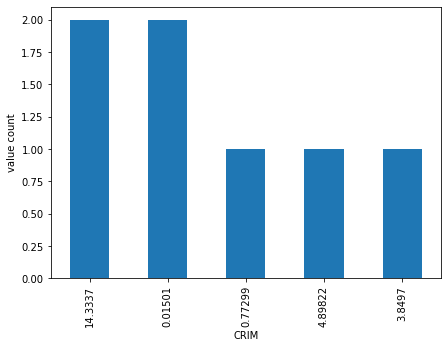

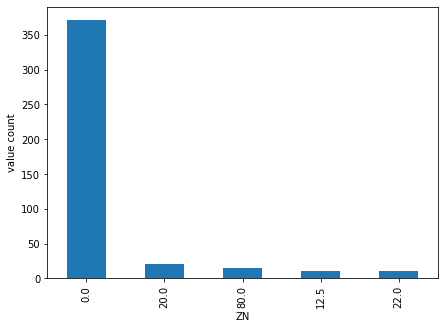

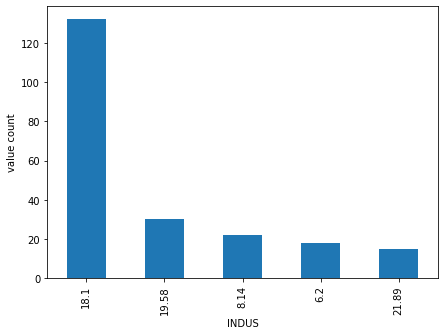

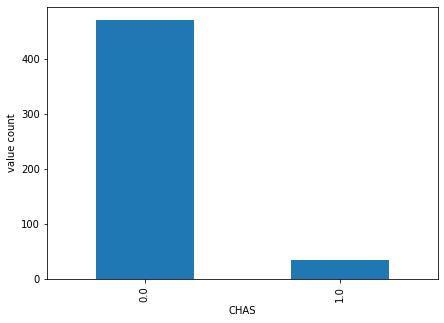

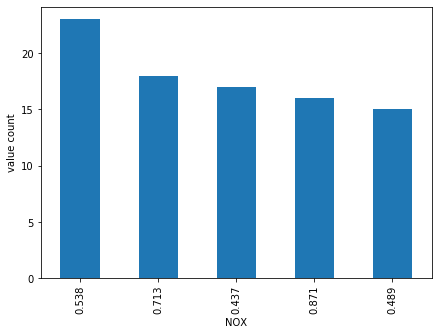

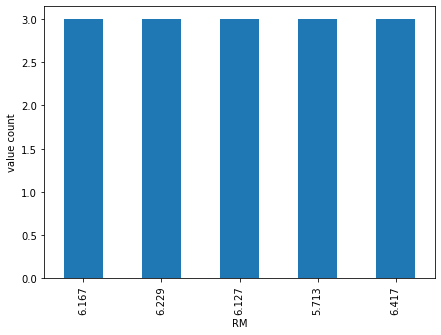

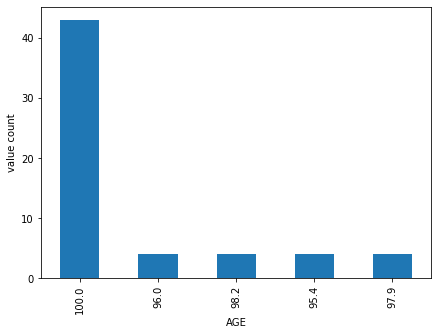

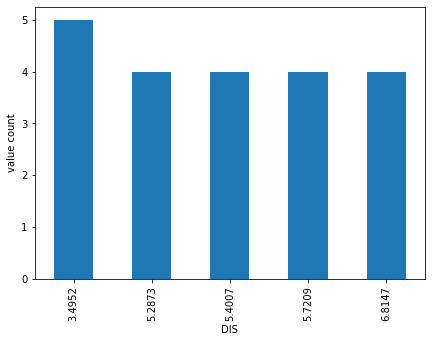

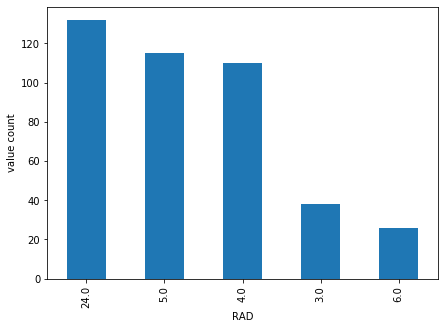

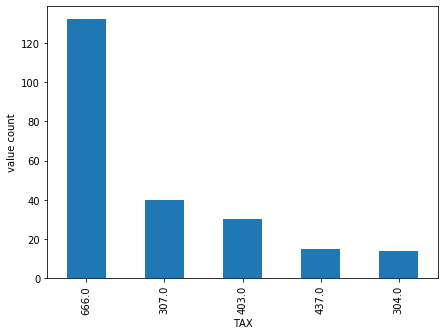

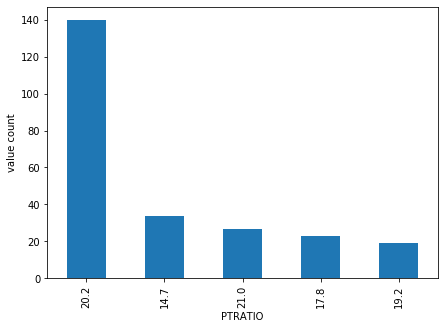

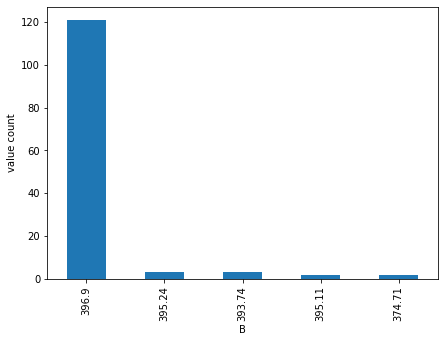

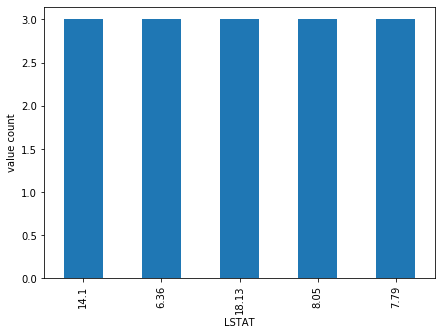

In [9]:
# Easier to make and much more readable
# Graph value counts 
for c in X.columns:
    plt.figure(figsize=(7,5))
    plt.xlabel(c);
    plt.ylabel('value count'); 
    X[c].value_counts().sort_values(ascending=False).head().plot.bar()

(<matplotlib.axes._subplots.AxesSubplot at 0x1a20a05490>,
              CRIM       ZN     INDUS       CHAS       NOX        RM       AGE  \
 CRIM     1.000000 -0.200469  0.406583 -0.055892  0.420972 -0.219247  0.352734   
  ZN     -0.200469  1.000000 -0.533828 -0.042697 -0.516604  0.311991 -0.569537   
 INDUS    0.406583 -0.533828  1.000000  0.062938  0.763651 -0.391676  0.644779   
 CHAS    -0.055892 -0.042697  0.062938  1.000000  0.091203  0.091251  0.086518   
 NOX      0.420972 -0.516604  0.763651  0.091203  1.000000 -0.302188  0.731470   
 RM      -0.219247  0.311991 -0.391676  0.091251 -0.302188  1.000000 -0.240265   
 AGE      0.352734 -0.569537  0.644779  0.086518  0.731470 -0.240265  1.000000   
 DIS     -0.379670  0.664408 -0.708027 -0.099176 -0.769230  0.205246 -0.747881   
 RAD      0.625505 -0.311948  0.595129 -0.007368  0.611441 -0.209847  0.456022   
 TAX      0.582764 -0.314563  0.720760 -0.035587  0.668023 -0.292048  0.506456   
 PTRATIO  0.289946 -0.391679  0.383248 -

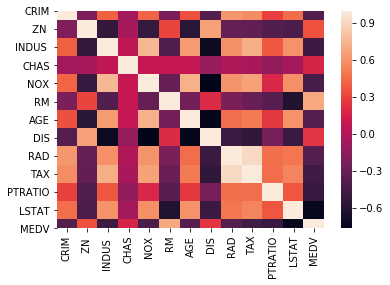

In [10]:
boston_data = './boston_data.csv'

df = pd.read_csv(boston_data)

sns.heatmap(df.corr()), df.corr()

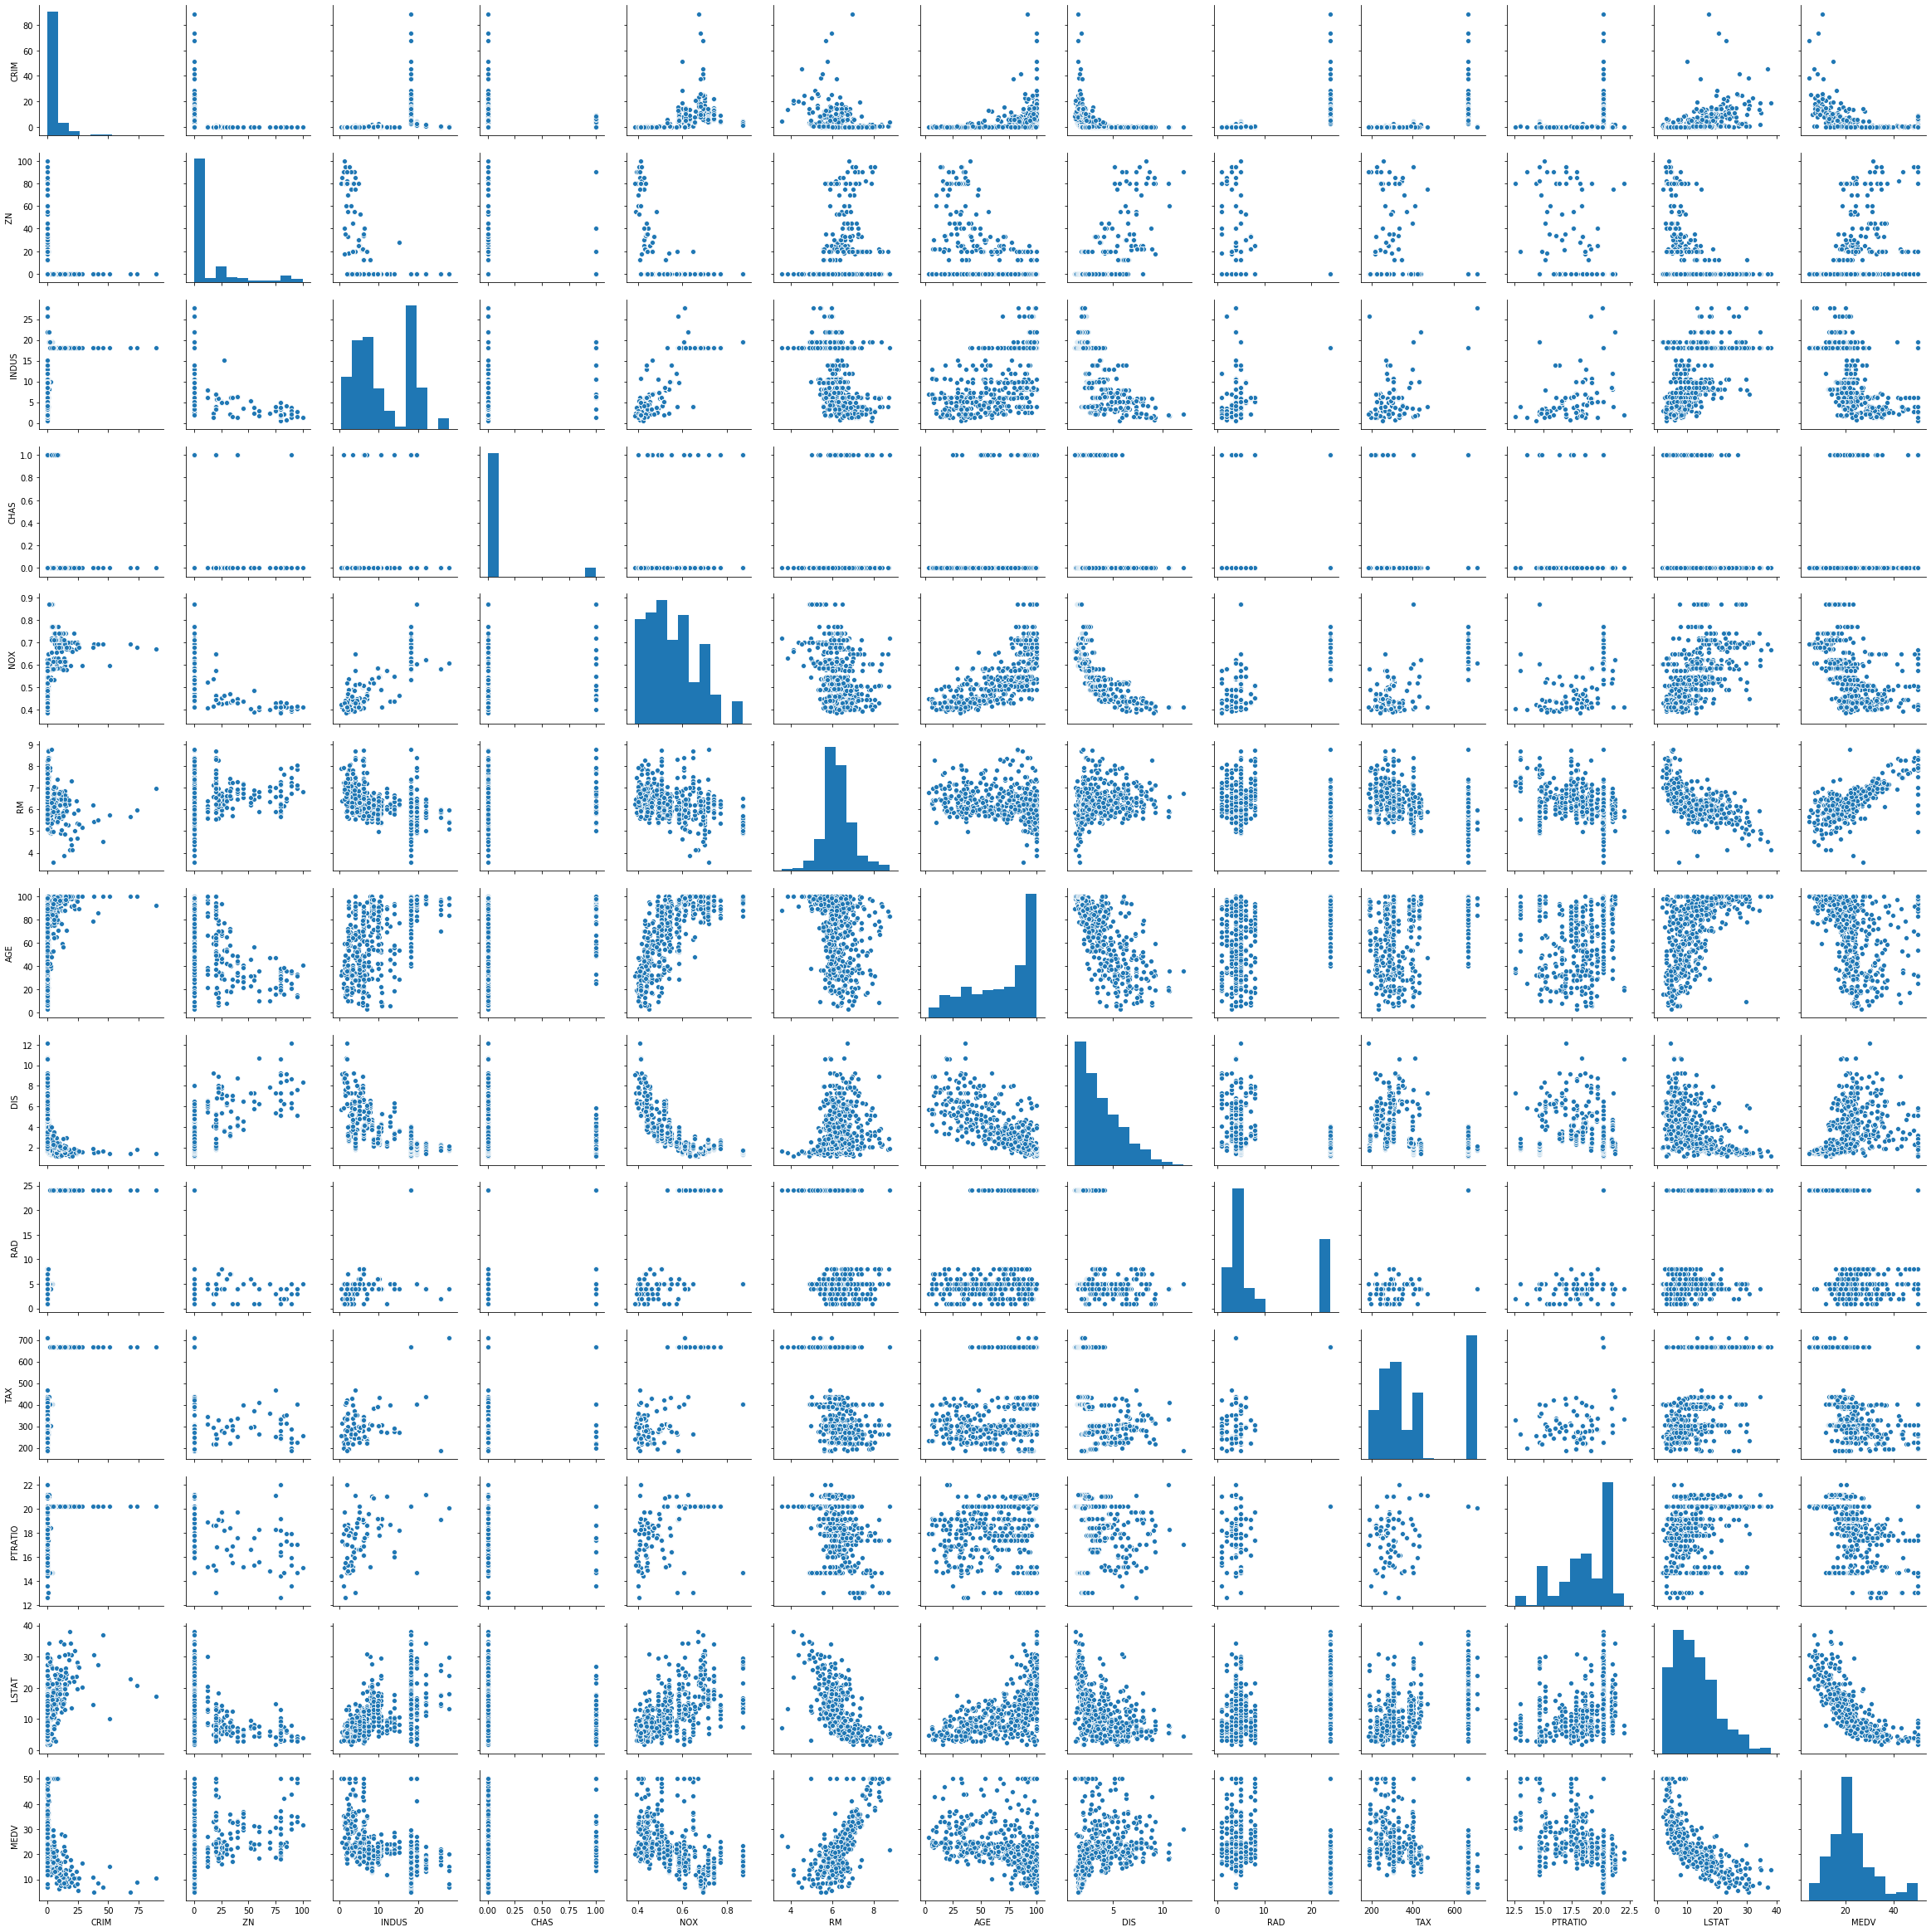

In [11]:
# much much easier
sns.pairplot(df);

## Using `scikit-learn` Linear Regression

### 2. Pick 3-4 predictors (i.e. CRIM, ZN, etc...) that you will use to predict our target variable, MEDV.
Score and plot your predictions. What do these results tell us?

In [12]:
boston_data = './boston_data.csv'

df = pd.read_csv(boston_data)
X = df[['LSTAT', 'RM', 'PTRATIO']]
y = df['MEDV']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Instantiate
lr = LinearRegression()
# Fit
lr.fit(X_train, y_train)
# Preds
lr_preds = lr.predict(X_test)
# Score
lr_score = lr.score(X_test, y_test)
lr_score

0.650904156861472

In [14]:
# set train to 90%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

# instantiate
lr_90 = LinearRegression()
# fit
lr_90.fit(X_train,y_train)
# predict
lr_90_preds = lr_90.predict(X_test)
# score
lr_90_score = lr_90.score(X_test,y_test)
lr_90_score

0.7452159446021683

In [15]:
#  For this particular data set an increase in training size vs test size from 70% to 90% 
#  resulted in a higher r^2 value by 9.4% from 65.1% to 74.5%

### 4. Use k-fold cross validation varying the number of folds from 5 to 10
What seems optimal? How do your scores change? What is the variance like? Try different folds to get a sense of how this impacts your score. What are the tradeoffs associated with choosing the number of folds?

In [16]:
gb = GradientBoostingRegressor()
n_folds = 5

params = {
    "learning_rate": [0.01, 0.025, 0.1, 1],
    "max_depth":[3, 8 ,10],
    "max_features":["sqrt"],
    }

gbr = GridSearchCV(gb, params, cv=n_folds, n_jobs=-1)
gbr.fit(X, y)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_no_change=None,
                

In [17]:
gbr_preds = gbr.predict(X_test)
gbr_preds

array([23.03192426, 31.27840432, 15.0416759 , 22.73679888, 15.72419551,
       20.82909689, 18.6355596 , 14.68911473, 20.84779666, 19.26419499,
       20.85885417, 20.07424059, 10.33296841, 21.06190805, 19.73169151,
       28.17833369, 19.99705611, 10.95704276, 47.7958092 , 15.45778084,
       24.50004343, 26.25068278, 13.50954367, 22.39819303, 16.33415229,
       14.0863419 , 21.49573049, 15.42654979, 21.21121476, 19.7648171 ,
       22.43160378, 23.68712829, 16.14190205, 21.22606255, 16.80318559,
       19.35347226, 34.0432855 , 19.97029626, 23.08986397, 23.35691003,
       19.6165127 , 27.73484414, 47.78865888, 18.5560053 , 23.29597651,
       15.11103574, 14.79321274, 23.8796227 , 17.71419335, 25.03184011,
       20.93861603])

In [19]:
gbr_score = gbr.score(X_test, y_test)
gbr_score

0.9728171121441804

In [20]:
gb = GradientBoostingRegressor()
n_folds = 10

params = {
    "learning_rate": [0.01, 0.025, 0.1, 1],
    "max_depth":[3, 8 ,10],
    "max_features":["sqrt"],
    }

gbr = GridSearchCV(gb, params, cv=n_folds, n_jobs=-1)
gbr.fit(X, y)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_no_change=None,
               

In [22]:
gbr_preds = gbr.predict(X_test)
gbr_preds

array([23.61860969, 30.75209147, 15.9826741 , 23.50943445, 16.13843856,
       21.54302276, 19.8925982 , 13.96842353, 19.79355472, 21.14130841,
       19.99432395, 19.9544079 , 12.8448565 , 21.54302276, 20.93177471,
       24.1464008 , 18.89042264, 12.56135383, 46.60263228, 16.10485685,
       23.99853464, 24.12064412, 13.4210337 , 21.57684922, 16.15274311,
       14.78940249, 23.30912864, 16.66140702, 19.8925982 , 21.02817977,
       20.60578078, 23.61749501, 21.27299127, 19.38959589, 14.18161346,
       19.21822574, 34.75208634, 20.21926877, 21.10314789, 23.61749501,
       16.63590741, 27.20986073, 44.89253204, 20.2627072 , 23.63899342,
       15.65945926, 16.0366767 , 23.78220317, 16.10485685, 26.99306646,
       21.4026348 ])

In [23]:
gbr_score = gbr.score(X_test, y_test)
gbr_score

0.8888118786183632

In [ ]:
# 5 Fold score = 0.972
# 10 Fold score = 0.888

# KNN Practice

In [34]:
# Read the iris data into a DataFrame
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'

col_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
iris = pd.read_csv(url, header=None, names=col_names)

In [37]:
iris.head()

# Increase the default figure and font sizes for easier viewing
# plt.rcParams['figure.figsize'] = (6, 4)
# plt.rcParams['font.size'] = 14

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [40]:
iris['species'].value_counts()

Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: species, dtype: int64

In [44]:
def species_number(row):
    if row['species'] == 'Iris-setosa':
        return 0
    if row['species'] == 'Iris-versicolor':
        return 1
    if row['species'] == 'Iris-virginica':
        return 2
    
iris['species_num'] = iris.apply(lambda row: species_number(row), axis=1)   

iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species,species_num
0,5.1,3.5,1.4,0.2,Iris-setosa,0
1,4.9,3.0,1.4,0.2,Iris-setosa,0
2,4.7,3.2,1.3,0.2,Iris-setosa,0
3,4.6,3.1,1.5,0.2,Iris-setosa,0
4,5.0,3.6,1.4,0.2,Iris-setosa,0


In [33]:
# Create a custom colormap
from matplotlib.colors import ListedColormap

cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

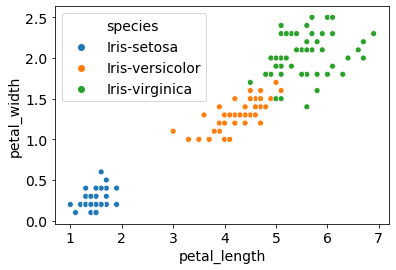

In [47]:
# Create a scatterplot of PETAL LENGTH versus PETAL WIDTH and color by SPECIES
sns.scatterplot(x='petal_length',y='petal_width' , hue='species', data=iris)

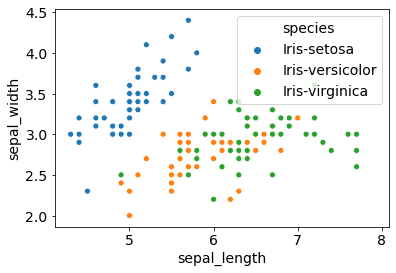

In [48]:
# Create a scatterplot of SEPAL LENGTH versus SEPAL WIDTH and color by SPECIES
sns.scatterplot(x='sepal_length',y='sepal_width' , hue='species', data=iris)

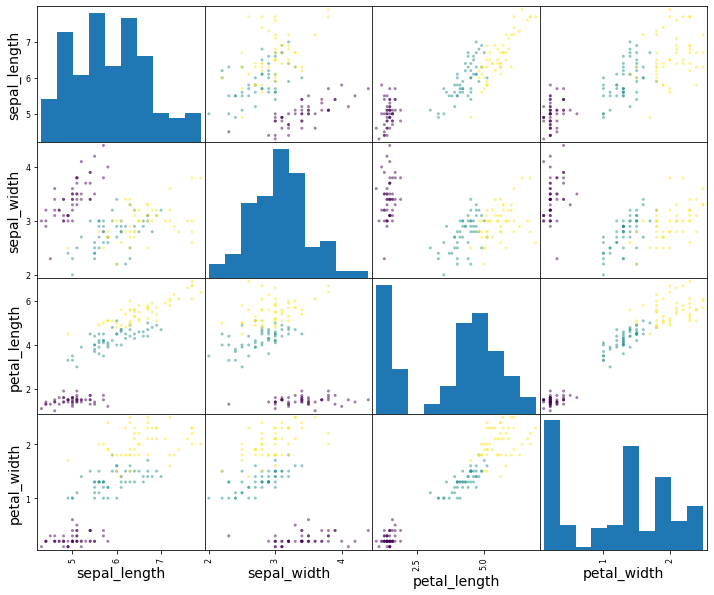

In [71]:
pd.plotting.scatter_matrix(iris.drop('species_num', axis=1), c=iris.species_num, figsize=(12, 10));


## KNN Classification of the Iris Dataset

### Create your feature matrix "X"
This will be all species measurements (sepal length, petal width, etc...)

In [49]:
X = iris[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']]
X.head()

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


### Create your target vector "y"
This will be the species type.

In [50]:
y = iris['species_num']

### Make Use of Train-Test-Split
Split your data in to train and test sets.

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

### Import KNN From `scikit-learn` and Instatiate a Model With One Neighbor

In [61]:
from sklearn.neighbors  import KNeighborsClassifier
from sklearn import metrics

kn = KNeighborsClassifier(n_neighbors=1)

### Check the Accuracy
Train your model using the training set then use the test set to determine the accuracy

In [62]:
kn.fit(X_train, y_train)
kn_pred = kn.predict(X_test)
kn_pred
print((metrics.accuracy_score(y_test, kn_pred)))

1.0


### Create a Model With Five Neighbors. Did it Improve?

In [69]:
kn_5 = KNeighborsClassifier(n_neighbors=5)
kn_5.fit(X, y)
kn_5_pred = kn.predict(X)
kn_5_pred
print((metrics.accuracy_score(y, kn_5_pred)))

1.0


### Create a Looped Function That Will Check All Levels of Various Neighbors and Calculate the Accuracy

In [67]:
scores = []
for k in range(1,100):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X,y)
    pred = knn.predict(X)
    score = float(sum(pred == y)) / len(y)
    scores.append([k, score])

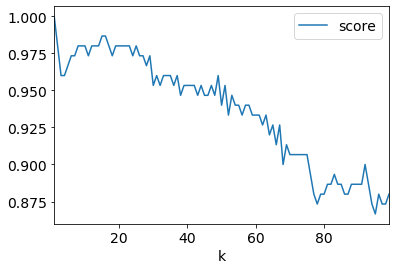

In [68]:
data = pd.DataFrame(scores,columns=['k','score'])
data.plot.line(x='k',y='score');

### Bonus: According to `scikit-learn` Documentation, What is `knn.predict_proba(X_new)` Going to Do?

In [70]:
knn.predict_proba(X)

array([[0.50505051, 0.45454545, 0.04040404],
       [0.50505051, 0.45454545, 0.04040404],
       [0.50505051, 0.44444444, 0.05050505],
       [0.50505051, 0.44444444, 0.05050505],
       [0.50505051, 0.45454545, 0.04040404],
       [0.50505051, 0.45454545, 0.04040404],
       [0.50505051, 0.44444444, 0.05050505],
       [0.50505051, 0.44444444, 0.05050505],
       [0.50505051, 0.43434343, 0.06060606],
       [0.50505051, 0.45454545, 0.04040404],
       [0.50505051, 0.46464646, 0.03030303],
       [0.50505051, 0.44444444, 0.05050505],
       [0.50505051, 0.45454545, 0.04040404],
       [0.50505051, 0.44444444, 0.05050505],
       [0.50505051, 0.46464646, 0.03030303],
       [0.50505051, 0.45454545, 0.04040404],
       [0.50505051, 0.45454545, 0.04040404],
       [0.50505051, 0.45454545, 0.04040404],
       [0.50505051, 0.46464646, 0.03030303],
       [0.50505051, 0.45454545, 0.04040404],
       [0.50505051, 0.46464646, 0.03030303],
       [0.50505051, 0.45454545, 0.04040404],
       [0.

## Enrichment
_Everything beyond this point is enrichment and examples using Statsmodels for linear regression._

### Example: Using the Statsmodels Formula

Adapt the formula example using your metrics. We will review this implementation in class. Here is a reference to consider. The workflow is the same, but the syntax is a little different. We want to get accustomed to the formula syntax because we will be using them a lot more with regressions. The results should be comparable to scikit-learn's regression models.

In [8]:
# First, format our data in a DataFrame

df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['MEDV'] = boston.target
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [9]:
# Set up our new statsmodel.formula handling model
import statsmodels.formula.api as smf

# You can easily swap these out to test multiple versions/different formulas
formulas = {
    "case1": "MEDV ~ RM + LSTAT + RAD + TAX + NOX + INDUS + CRIM + ZN - 1", # - 1 = remove intercept
    "case2": "MEDV ~ NOX + RM",
    "case3": "MEDV ~ RAD + TAX"
}

model = smf.ols(formula=formulas['case1'], data=df)
result = model.fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   MEDV   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                     1220.
Date:                Wed, 29 Nov 2017   Prob (F-statistic):          1.59e-321
Time:                        22:28:38   Log-Likelihood:                -1567.7
No. Observations:                 506   AIC:                             3151.
Df Residuals:                     498   BIC:                             3185.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
RM             4.9744      0.224     22.197      0.000       4.534       5.415
LSTAT         -0.5615      0.048    -11.817      0.000      -0.655      -0.468
RAD            0.2109      0.070      3.025      0.003       0.074       0.348
TAX           -0.0174      0.004     -4.267      0.000      -0.025      -0.009
NOX            4.3456      3.385      1.284      0.200      -2.305      10.997
INDUS          0.0925      0.067      1.385      0.167      -0.039       0.224
CRIM          -0.0866      0.037     -2.362      0.019      -0.159      -0.015
ZN             0.0288      0.013      2.215      0.027       0.003       0.054
==============================================================================
Omnibus:                      192.072   Durbin-Watson:                   0.812
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              831.634
Skew:                           1.665   Prob(JB):                    2.59e-181
Kurtosis:                       8.325   Cond. No.                     6.24e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.24e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Bonus Challenge #1:

Can you optimize your R2, selecting the best features and using either test-train split or k-folds?

### Bonus Challenge #2:

Given a combination of predictors, can you find another response variable that can be accurately predicted through the exploration of different predictors in this data set?

_Tip: Check out pairplots, coefficients, and Pearson scores._

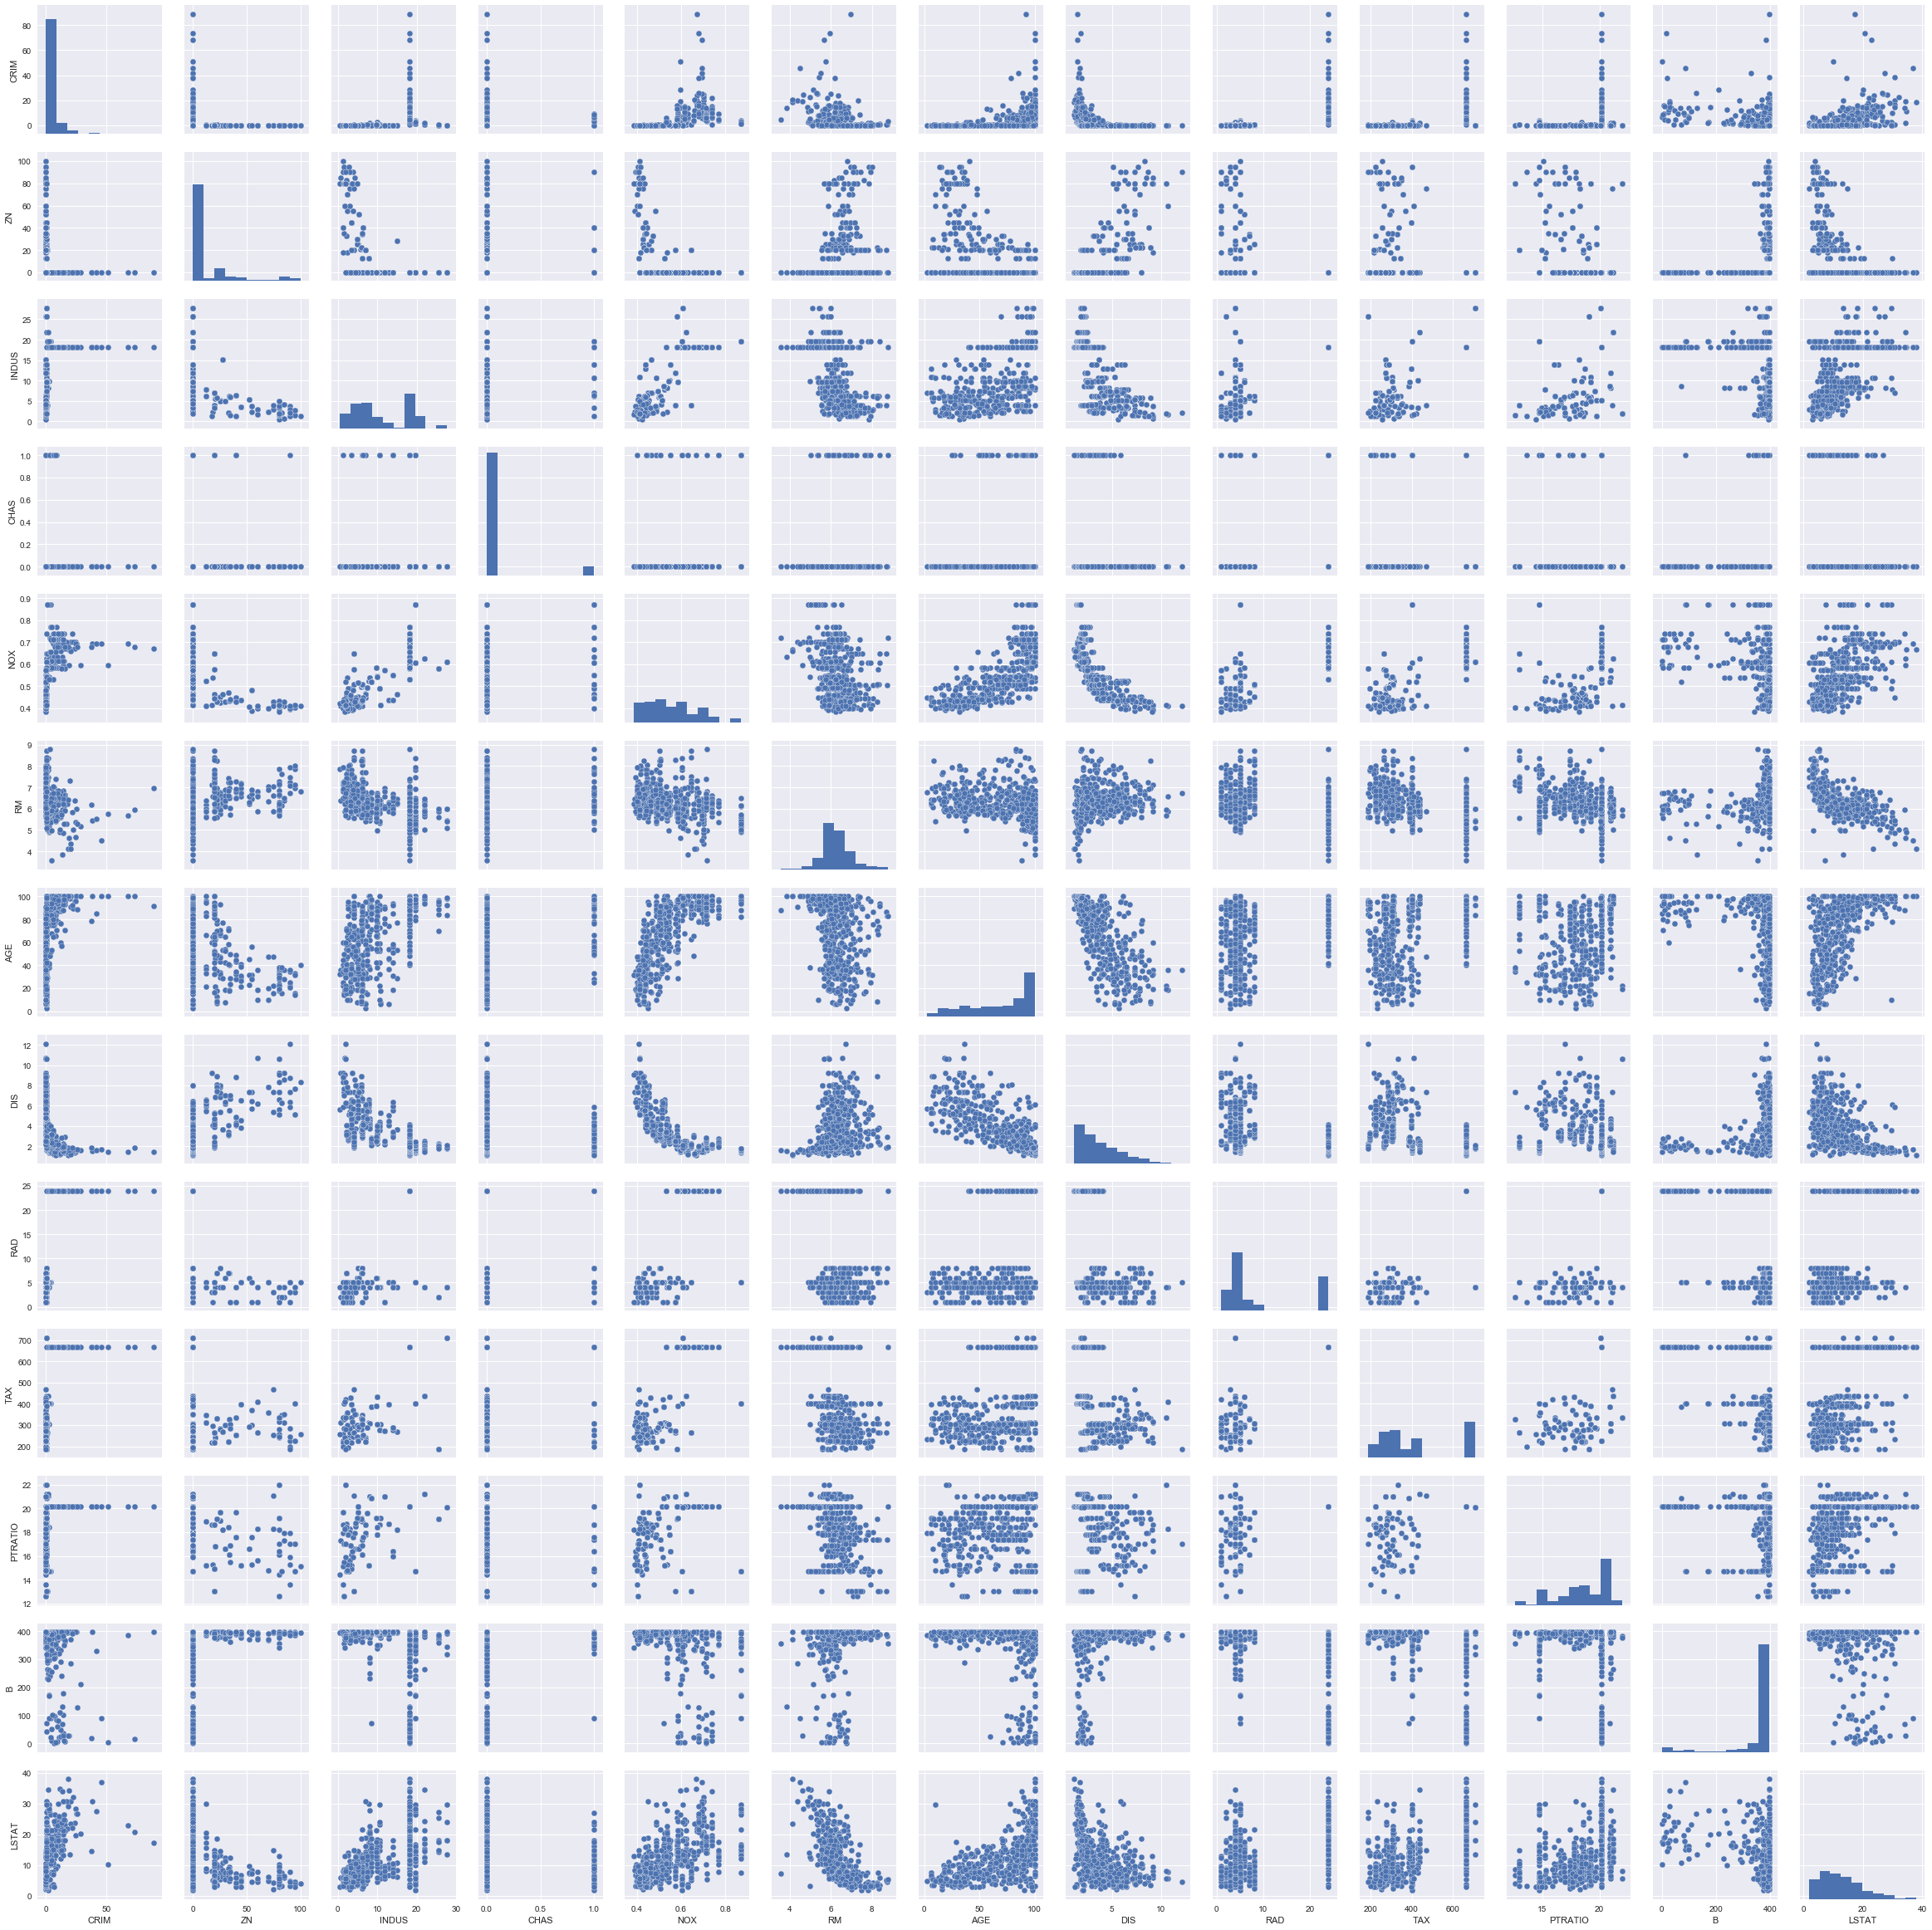

In [10]:
# Check out variable relations
import seaborn as sns

sns.pairplot(X);

In [ ]:
# Check out Pearson scores


## Demo: Patsy

In [11]:
import patsy

# Add response to the core DataFrame
df['MEDV'] = y

In [12]:
from sklearn.model_selection import train_test_split #If you didn't import it earlier, do so now

# Easily change your variable predictors without reslicing your DataFrame
y, X = patsy.dmatrices("MEDV ~ AGE + RM", data=df, return_type="dataframe")

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7)


In [13]:
from sklearn import metrics
from sklearn.linear_model import LinearRegression

# Rerun your model, iteratively changing your variables and train_size from the previous cell

lm = LinearRegression()
model = lm.fit(X_train, y_train)

predictions = model.predict(X_test)
print("R^2 Score: {}".format(metrics.r2_score(y_test, predictions)))

R^2 Score: 0.5043486813354807
